# GPyTorch on L2P training data

Adapted from [GPyTorch](https://docs.gpytorch.ai/en/stable/examples/02_Scalable_Exact_GPs/Simple_MultiGPU_GP_Regression.html) tutorial.

In [35]:
import xarray as xr
import math
import torch
import gpytorch
import sys
from matplotlib import pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import sys
#sys.path.append('/home/jovyan/infrastructure/notebooks')
from LBFGS import FullBatchLBFGS

## Get the data
downloaded subset of l2p viirs data from Jacob's nb in `data-preprocessing` repo

In [37]:
#from Jacob

viirs = xr.open_dataset('/home/argray/Downloads/viirs_20180701-20180707.nc',)


In [38]:
#convert lat, lon, time, sst to np arrays
lat = viirs.lat.values
lon = viirs.lon.values
time = viirs.time.values.astype('float64')
sst = viirs.sea_surface_temperature.values
#try this here with dt_analysis ?

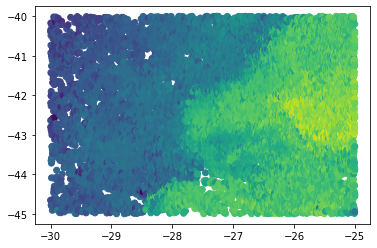

In [39]:
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rcParams['agg.path.chunksize'] = 10000

plt.scatter(lat[::100], lon[::100], c=sst[::100])
plt.show()

In [62]:
fulldata = np.array([lat, lon, time, sst]).T
data = fulldata[::120,:]
test_data = fulldata[1::120,:]
data = torch.Tensor(data)
test_data = torch.Tensor(test_data)
test_data.shape

torch.Size([11062, 4])

In [63]:
## Normalization and train/test splits

train_x, train_y = data[:,:-1], data[:,-1] 
test_x, test_y = test_data[:,:-1], test_data[:,-1] 

# normalize features
meanx = train_x.mean(dim=-2, keepdim=True)
stdx = train_x.std(dim=-2, keepdim=True) + 1e-6  # prevent dividing by 0

train_x = (train_x - meanx) / stdx
test_x = (test_x - meanx) / stdx

# normalize labels
meany, stdy = train_y.mean(),train_y.std()
train_y = (train_y - meany) / stdy
test_y = (test_y - meany) / stdy

# make continguous
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

output_device = torch.device('cuda:0')

train_x, train_y = train_x.to(output_device), train_y.to(output_device)
test_x, test_y = test_x.to(output_device), test_y.to(output_device)

## Define GP model and training code

In [64]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        # base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))
        
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))
        #self.covar_module = gpytorch.kernels.MultiDeviceKernel(
        #    base_covar_module, device_ids=range(n_devices),
        #    output_device=output_device
        #)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

train_x = train_x.cuda()
train_y = train_y.cuda()
model = model.cuda()
likelihood = likelihood.cuda()

## Training

In [65]:
torch.cuda.empty_cache() 
print(torch.cuda.is_available()) 

True


In [68]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100

for i in range(training_iter):    
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    
    
    print('Iter %d/%d - Loss: %.3f' % (
        i + 1, training_iter, loss.item()
    ))
    optimizer.step()    

Iter 1/100 - Loss: -0.038
Iter 2/100 - Loss: -0.040
Iter 3/100 - Loss: -0.021
Iter 4/100 - Loss: -0.027
Iter 5/100 - Loss: -0.026
Iter 6/100 - Loss: -0.040
Iter 7/100 - Loss: -0.044
Iter 8/100 - Loss: -0.045
Iter 9/100 - Loss: -0.037
Iter 10/100 - Loss: -0.045
Iter 11/100 - Loss: -0.049
Iter 12/100 - Loss: -0.039
Iter 13/100 - Loss: -0.029
Iter 14/100 - Loss: -0.028
Iter 15/100 - Loss: -0.028
Iter 16/100 - Loss: -0.012
Iter 17/100 - Loss: -0.002
Iter 18/100 - Loss: -0.017
Iter 19/100 - Loss: -0.024
Iter 20/100 - Loss: -0.028
Iter 21/100 - Loss: -0.024
Iter 22/100 - Loss: -0.037
Iter 23/100 - Loss: -0.042
Iter 24/100 - Loss: -0.043
Iter 25/100 - Loss: -0.044
Iter 26/100 - Loss: -0.045
Iter 27/100 - Loss: -0.047
Iter 28/100 - Loss: -0.032
Iter 29/100 - Loss: -0.030
Iter 30/100 - Loss: -0.022
Iter 31/100 - Loss: -0.043
Iter 32/100 - Loss: -0.036
Iter 33/100 - Loss: -0.040
Iter 34/100 - Loss: -0.050
Iter 35/100 - Loss: -0.053
Iter 36/100 - Loss: -0.043
Iter 37/100 - Loss: -0.044
Iter 38/10

In [69]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

test_rmse = torch.sqrt(torch.mean(torch.pow(mean - test_y, 2)))
print(f"Test RMSE: {test_rmse.item()}")

mean = mean.cpu().numpy()
var_x = test_x.cpu().numpy()
latx = var_x[:,0]
lonx = var_x[:,1]

Test RMSE: 0.2058924436569214


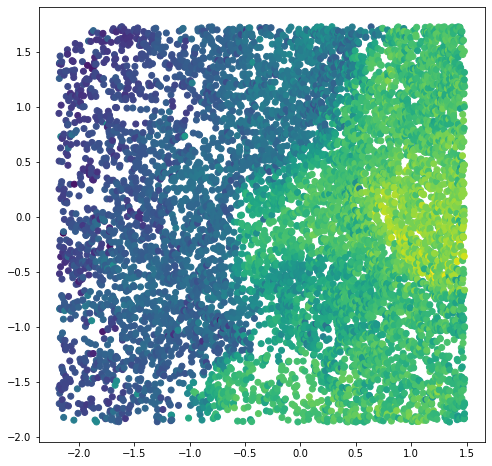

In [58]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Plot training data as black stars
    ax.scatter(latx, lonx, c=mean)
    

In [71]:
### NEED help here with getting test-lat/lon/time in the right format


#to map data at 1 km resolution, at 3 hrly increments 
model.eval()
likelihood.eval()

#test_lat = -45:.01:-40
#test_lon = -30:.01:-25
#test_time = 20180701 to 20180706, in 3 hrly increments?
test_x = np.array([test_lat, test_lon, test_time]).T
test_x = torch.Tensor(test_x)

test_x = (test_x - meanx) / stdx

# make continguous
test_x = test_x.contiguous()
test_x = test_x.to(output_device)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    pred_sst = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

pred_sst = (stdy * pred_sst) + meany    
pred_sst = pred_sst.cpu().numpy()


SyntaxError: invalid syntax (430779593.py, line 4)

In [119]:
lscl = model.covar_module.base_kernel.lengthscale.cpu().detach().numpy()
latscl = stdx.cpu().detach().numpy() * (lscl)
print(latscl.flat[0], latscl.flat[1], latscl.flat[2] / 1e9 / 24 / 3600)

0.14567927 0.15976824 0.5617209495703703
